In [1]:
import os
import tarfile
import matplotlib.pyplot as plt
import pandas as pd
import torch
from pathlib import Path
from NeuralNMF import train
from sklearn.feature_extraction.text import TfidfVectorizer
from NeuralNMF import Neural_NMF
import pickle
import scipy.io
import random
import numpy as np


np.random.seed(0)
random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)


In [3]:
def NNMF(dataset,layers,day,mouse,timeframes = 3):
    trainS = dataset["S"][0][day]
    opto = dataset["opt"][0][day]

    layers.insert(0,trainS.shape[0]*timeframes)

    trainData = []
    for i in range(trainS.shape[1]-timeframes+1):
        segment = trainS[:,i:i+timeframes]
        flatt = segment.flatten(order='F')
        trainData.append(flatt)
    trainMatrix = np.array(trainData).T

    train__ = torch.tensor(trainMatrix)
    net = Neural_NMF(layers)
    history = train(net, train__, epoch=10, lr=500, supervised=False)

    A = history[0][len(layers)-2]
    S = history[1][len(layers)-2]
    A1 = history[0][0].detach().numpy()
    Afinal = A.detach().numpy()
    S1 = S.detach().numpy()

    # count_ones = np.count_nonzero(opto == 1)
    opto = opto.flatten()
    opto_extra = opto
    opto_extra[1:] = np.diff(opto) == 1
    opto_extra[0] = opto[0]  # Retain the
    indices = np.where(opto_extra == 1)[0]
    slices = []
    for idx in indices:
        if idx + 20 <= S1.shape[1]:
            slices.append(S1[:, idx:idx+20])
        else:
            slices.append(S1[:, idx:])
    C = np.hstack(slices) if slices else np.array([])

    # if(len(layers)>2):
    #     a1 = history[0][0]
    #     a2 = history[0][1]
    #     a1a2 = torch.matmul(a1,a2)
    #     a12_ = a1a2[:,0]
    #     o,p,n = a12_[:trainS.shape[0]],a12_[trainS.shape[0]:trainS.shape[0]*2],a12_[trainS.shape[0]*2:trainS.shape[0]*3]
    #     o,p,n = o.reshape(-1,1),p.reshape(-1,1),n.reshape(-1,1)
    #     result_matrix = torch.cat((o, p, n), dim=1)

    #     plt.imshow(result_matrix.detach().numpy(), cmap='hot', interpolation='nearest')
    #     plt.colorbar()  # Show color scale
    #     plt.title('Heat Map of PyTorch Tensor A1*A2')
    #     plt.show()

    plt.imshow(A1[:,:], cmap='inferno', interpolation='nearest')
      # Show color scale
    plt.title(r'Heat map of $W^{(1)}$, ' f'for Session {day+1}')
    plt.show()

    plt.imshow(Afinal[:,:], cmap='coolwarm', interpolation='nearest')
    plt.colorbar()  # Show color scale
    plt.title(r'Heat map of $W^{(2)}$, ' f'for Session {day+1}')
    plt.show()

    plt.imshow(C[:,:100], cmap='plasma', interpolation='nearest')
    plt.colorbar()  # Show color scale
    plt.title(r'Heat map of H ' f'matrix for Session {day+1}')
    plt.show()

    #activations of neurons

    number = layers[1]
    y = np.arange(1, number+1)
    # Create the horizontal stacked bar graph
    fig, ax = plt.subplots(figsize=(5, number*0.1))  # Adjust the size to fit the labels better
    bar_height = 0.35
    index = np.arange(number)
    # Plot the bars
    bar1 = ax.barh(index, Afinal[:number, 0], bar_height, label='Column 1')
    bar2 = ax.barh(index, Afinal[:number, 1], bar_height, left=Afinal[:number, 0], label='Column 2')
    # Adding labels and title
    ax.set_ylabel('Neurons')
    ax.set_xlabel('Activation Value')
    ax.set_title(r'Activation of Each Neuron in $W^{(2)}$ 'f'matrix for Session {day+1}')
    ax.set_yticks(index)
    ax.legend()
    plt.show()

    S2 = (A@S).detach().numpy()
    slices = []
    for idx in indices:
        if idx + 20 <= S2.shape[1]:
            slices.append(S2[:, idx:idx+10])
        else:
            slices.append(S2[:, idx:])
    D = np.hstack(slices) if slices else np.array([])

    plt.imshow(D[:,0:100], cmap='hot', interpolation='nearest')
    plt.title(r'Heat map of $H^{(1)}$ ' f'matrix for Session {day+1}')
    plt.show()

    return history,Afinal,S1,C

100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


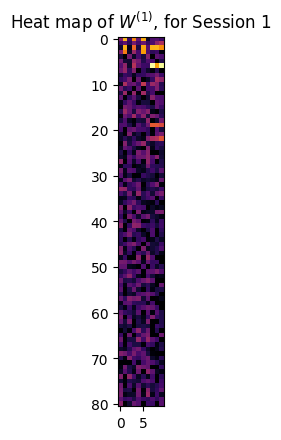

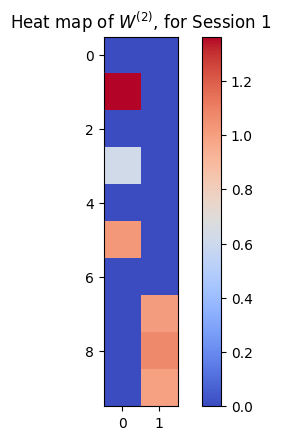

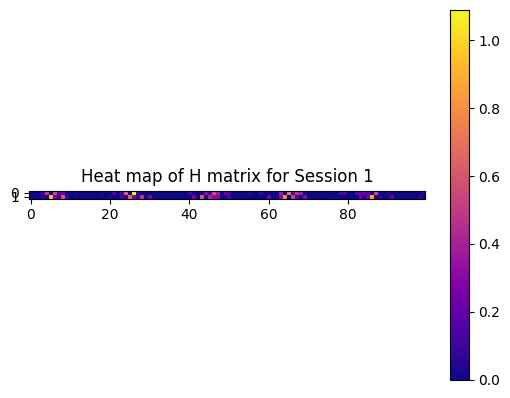

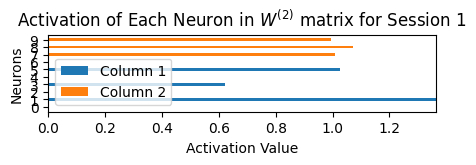

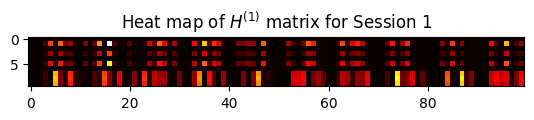

In [4]:
mouse = 18
mat_data = scipy.io.loadmat(rf"C:\Users\ASUS\Downloads\For_Tezuka\For_Tezuka\Opto_Data_CLa{mouse}.mat")
for day in range(1):
    timeframe = 1
    layers = [10,2]
    history,A1,S1,C = NNMF(mat_data,layers,day,mouse,timeframe)

In [6]:
type(mat_data)

dict

In [3]:
trainS = mat_data["S"][0][0]

In [4]:
i=3000

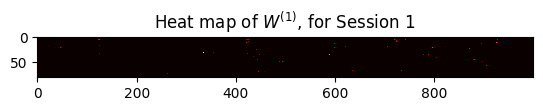

In [5]:
plt.imshow(trainS[:,i:i+1000], cmap='hot', interpolation='nearest')
      # Show color scale
plt.title(r'Heat map of $W^{(1)}$, ' f'for Session {1}')
plt.show()

In [6]:
new = trainS.sum(axis=0)

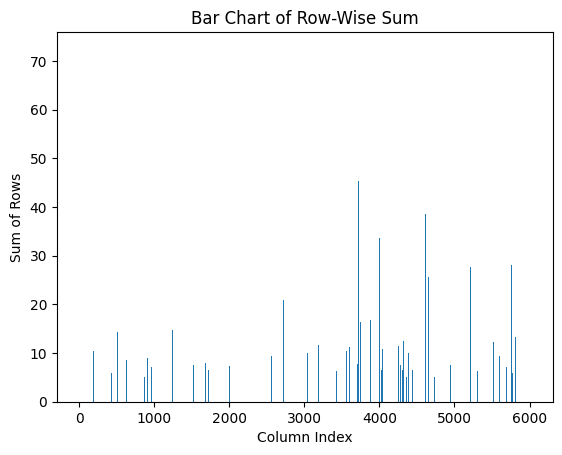

In [7]:
x = range(len(new))

plt.bar(x, new)
plt.title('Bar Chart of Row-Wise Sum')
plt.xlabel('Column Index')
plt.ylabel('Sum of Rows')
plt.show()

In [5]:
opto = mat_data["opt"][0][3]

In [6]:
opto

array([[0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [7]:
S1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
row_sum = S1.sum(axis = 0)

In [8]:
row_sum.shape

(6012,)

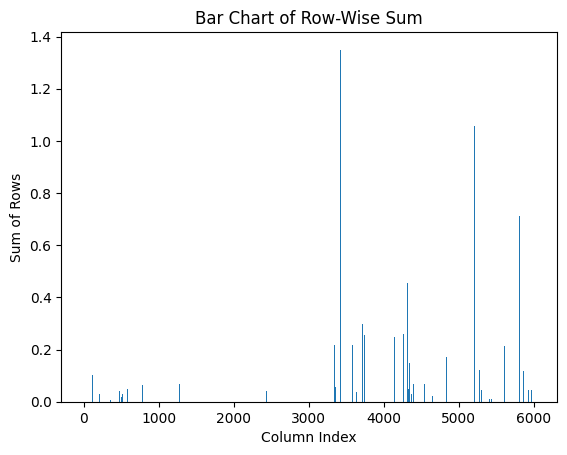

In [9]:
x = range(len(row_sum))

plt.bar(x, row_sum)
plt.title('Bar Chart of Row-Wise Sum')
plt.xlabel('Column Index')
plt.ylabel('Sum of Rows')
plt.show()

In [8]:
opto = opto.flatten()

In [9]:
indices = np.where(opto == 1)[0]



In [10]:
indices

array([ 139,  140,  141,  142,  143,  144,  145,  146,  147,  148,  437,
        438,  439,  440,  441,  442,  443,  444,  445,  446,  735,  736,
        737,  738,  739,  740,  741,  742,  743,  744, 1033, 1034, 1035,
       1036, 1037, 1038, 1039, 1040, 1041, 1042, 1331, 1332, 1333, 1334,
       1335, 1336, 1337, 1338, 1339, 1629, 1630, 1631, 1632, 1633, 1634,
       1635, 1636, 1637, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934,
       1935, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2523,
       2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2820, 2821, 2822,
       2823, 2824, 2825, 2826, 2827, 2828, 2829], dtype=int64)

In [13]:
indices.shape

(95,)

In [14]:
opto.shape

(6012,)

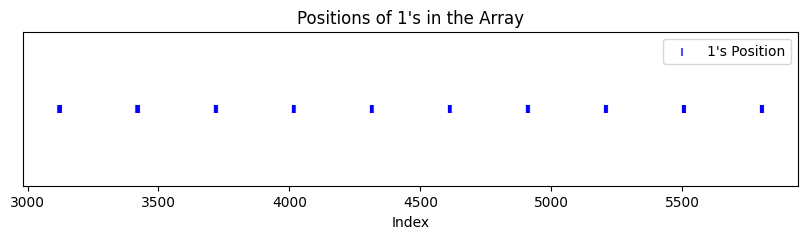

In [15]:
plt.figure(figsize=(10, 2))
plt.scatter(indices, [1] * len(indices), color='blue', marker='|', alpha=0.7, label="1's Position")
plt.title("Positions of 1's in the Array")
plt.xlabel("Index")
plt.yticks([])
plt.legend()
plt.show()


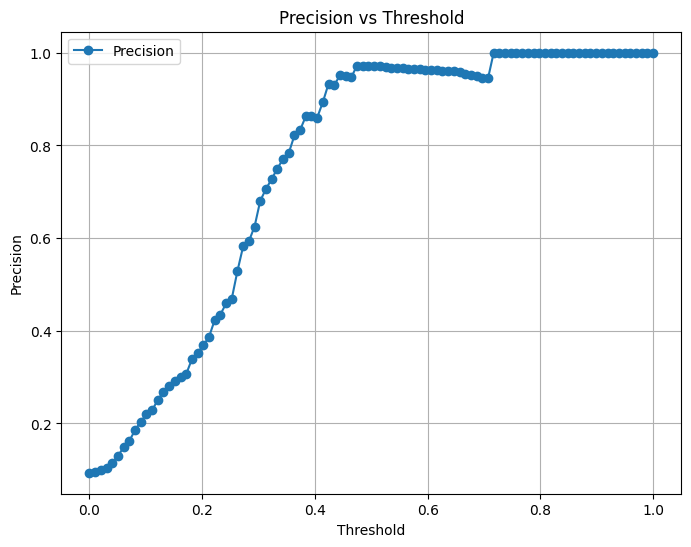

In [26]:
thresholds = np.linspace(0, 1, 100) 
precisions = [] 
for threshold in thresholds:
    # Find indices where the sum exceeds the threshold
    above_threshold_indices = np.where(row_sum > threshold)[0]

    # Find synchronized occurrences
    synchronized_indices = above_threshold_indices[opto[above_threshold_indices] == 1]

    # Calculate precision
    precision = len(synchronized_indices) / len(above_threshold_indices) if len(above_threshold_indices) > 0 else 0
    precisions.append(precision)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.title('Precision vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.grid(True)
plt.legend()
plt.show()


In [20]:
opto = mat_data["opt"][0][0]

In [22]:
opto = opto.flatten()

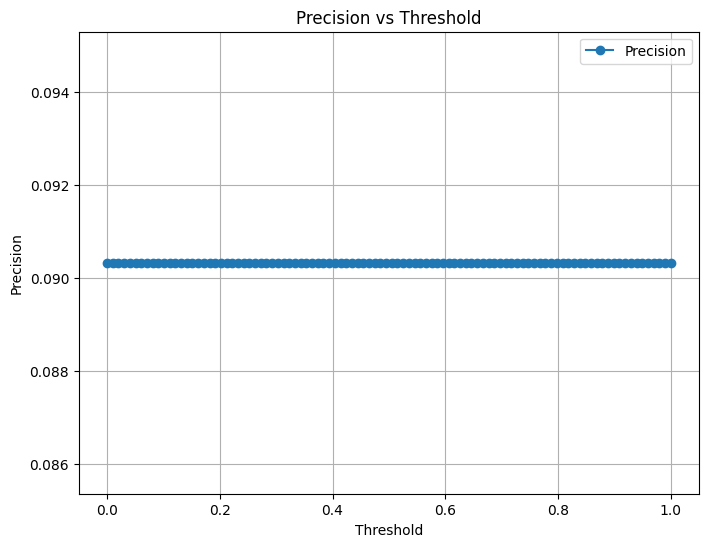

In [10]:
row_sum = new
thresholds = np.linspace(0, 1, 100) 
precisions = [] 
for threshold in thresholds:
    # Find indices where the sum exceeds the threshold
    above_threshold_indices = np.where(row_sum > threshold)[0]

    # Find synchronized occurrences
    synchronized_indices = above_threshold_indices[opto[above_threshold_indices] == 1]

    # Calculate precision
    precision = len(synchronized_indices) / len(above_threshold_indices) if len(above_threshold_indices) > 0 else 0
    precisions.append(precision)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.title('Precision vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.grid(True)
plt.legend()
plt.show()

In [27]:
synchronized_indices

array([3422, 5208, 5508, 5805], dtype=int64)

In [28]:
above_threshold_indices

array([3422, 5208, 5508, 5805], dtype=int64)

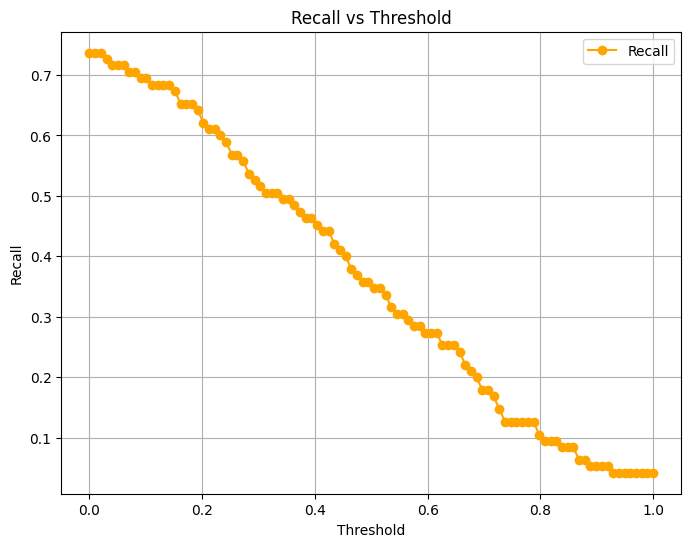

In [29]:
thresholds2 = np.linspace(0, 1, 100)  # 100 thresholds from 0 to 1
recalls = []

total_ones = np.sum(opto)  # Total number of 1's in array_1

for threshold in thresholds2:
    # Find indices where the sum exceeds the threshold
    above_threshold_indices = np.where(row_sum > threshold)[0]

    # Find synchronized occurrences
    synchronized_indices = above_threshold_indices[opto[above_threshold_indices] == 1]

    # Calculate recall
    recall = len(synchronized_indices) / total_ones if total_ones > 0 else 0
    recalls.append(recall)

# Step 3: Plot recall vs threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, recalls, label='Recall', marker='o', color='orange')
plt.title('Recall vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.grid(True)
plt.legend()
plt.show()

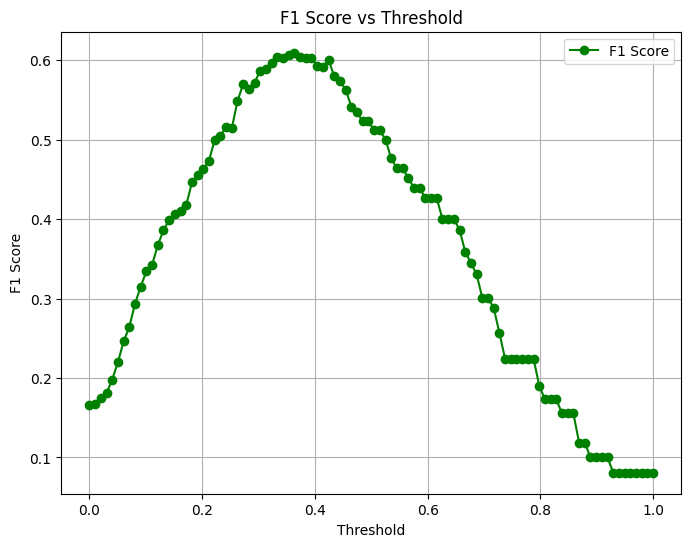

In [30]:
thresholds3 = np.linspace(0, 1, 100)  # 100 thresholds from 0 to 1
precisions = []
recalls = []
f1_scores = []

total_ones = np.sum(opto)  # Total number of 1's in array_1

for threshold in thresholds3:
    # Find indices where the sum exceeds the threshold
    above_threshold_indices = np.where(row_sum > threshold)[0]

    # Find synchronized occurrences
    synchronized_indices = above_threshold_indices[opto[above_threshold_indices] == 1]

    # Calculate precision
    precision = len(synchronized_indices) / len(above_threshold_indices) if len(above_threshold_indices) > 0 else 0
    precisions.append(precision)

    # Calculate recall
    recall = len(synchronized_indices) / total_ones if total_ones > 0 else 0
    recalls.append(recall)

    # Calculate F1 score
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0
    f1_scores.append(f1)

# Step 3: Plot F1 Score vs Threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', marker='o', color='green')
plt.title('F1 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.legend()
plt.show()


In [31]:
opto = opto.flatten()
opto_extra = opto
opto_extra[1:] = np.diff(opto) == 1
opto_extra[0] = opto[0]  # Retain the first value if it's a 1

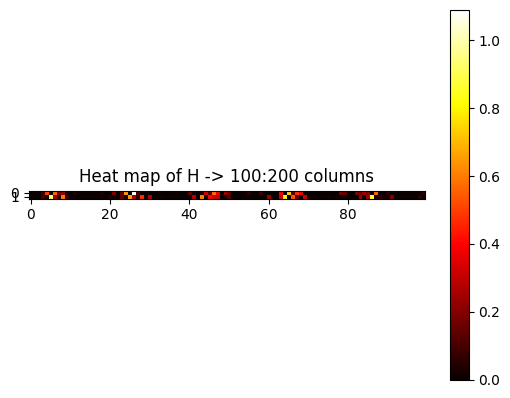

In [32]:
i = 0
plt.imshow(C[:,i:i+100], cmap='hot', interpolation='nearest')
plt.colorbar()  # Show color scale
plt.title(r'Heat map of H -> 100:200 columns')
plt.show()

In [33]:
indexing = np.where(opto_extra==1)[0]
indexing

array([3118, 3416, 3714, 4012, 4310, 4608, 4906, 5204, 5501, 5799],
      dtype=int64)

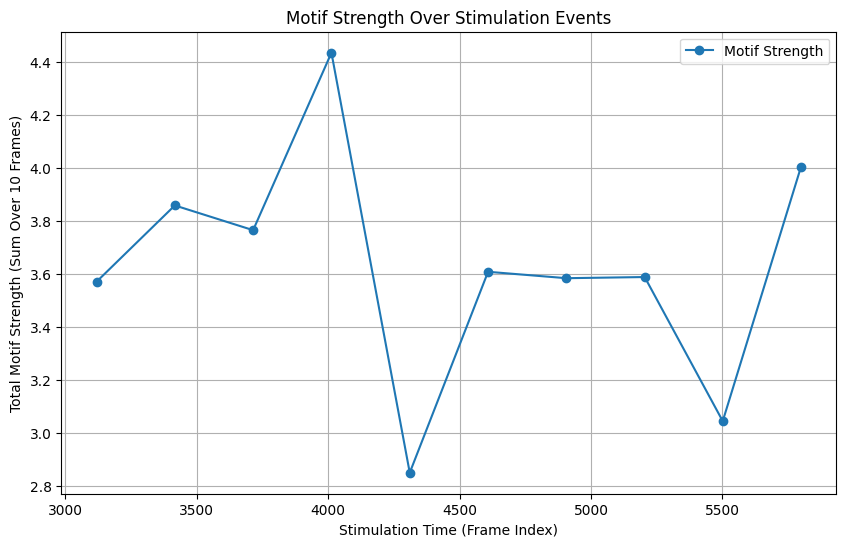

In [82]:
motif_strengths = []

for idx in indexing:
    if idx + 10 <= S1.shape[1]:  # Ensure we don't exceed bounds
        motif_strength = S1[:, idx:idx + 10].sum()
        motif_strengths.append(motif_strength)

# Convert results to arrays for plotting
motif_strengths = np.array(motif_strengths)
stim_times = indexing[:len(motif_strengths)]  # Corresponding stimulation times

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(stim_times, motif_strengths, marker='o', linestyle='-', label='Motif Strength')
plt.title('Motif Strength Over Stimulation Events')
plt.xlabel('Stimulation Time (Frame Index)')
plt.ylabel('Total Motif Strength (Sum Over 10 Frames)')
plt.grid(True)
plt.legend()
plt.show()

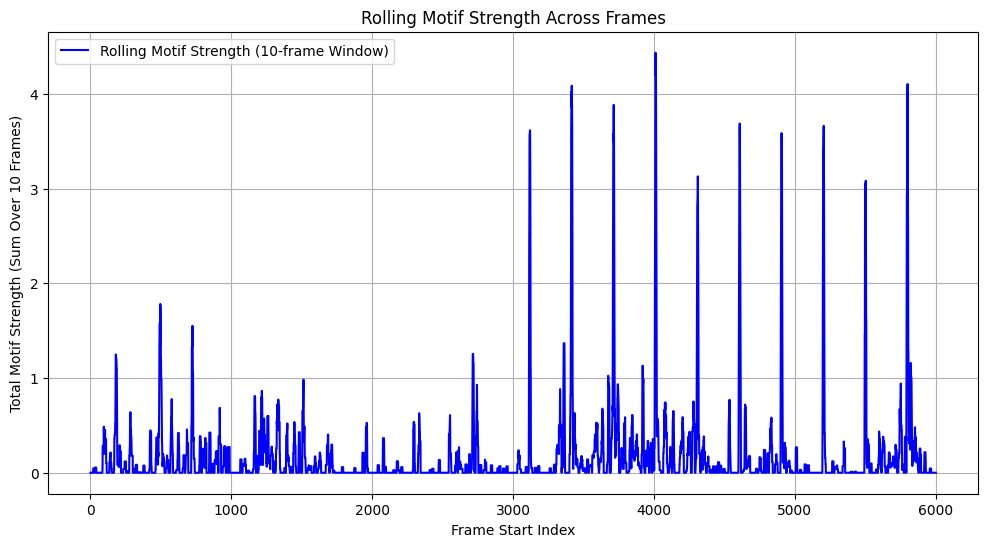

In [34]:
frame_window = 10

# Rolling sum for the H matrix
rolling_sums = []
for i in range(S1.shape[1] - frame_window + 1):
    rolling_sum = S1[:, i:i + frame_window].sum()  # Sum over the window
    rolling_sums.append(rolling_sum)

rolling_sums = np.array(rolling_sums)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(rolling_sums, label='Rolling Motif Strength (10-frame Window)', color='blue')
plt.title('Rolling Motif Strength Across Frames')
plt.xlabel('Frame Start Index')
plt.ylabel('Total Motif Strength (Sum Over 10 Frames)')
plt.grid(True)
plt.legend()
plt.show()

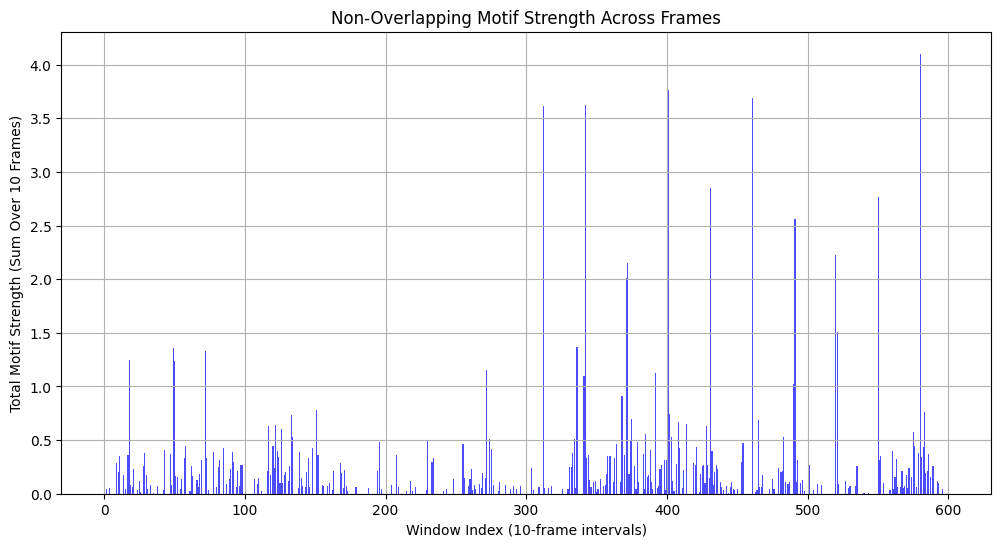

In [36]:
frame_window = 10

non_overlapping_sums = []
for i in range(0, S1.shape[1], frame_window):
    if i + frame_window <= S1.shape[1]:  # Ensure we stay within bounds
        non_overlapping_sum = S1[:, i:i + frame_window].sum()  # Sum over the window
        non_overlapping_sums.append(non_overlapping_sum)

non_overlapping_sums = np.array(non_overlapping_sums)

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(range(len(non_overlapping_sums)), non_overlapping_sums, color='blue', alpha=0.7)
plt.title('Non-Overlapping Motif Strength Across Frames')
plt.xlabel('Window Index (10-frame intervals)')
plt.ylabel('Total Motif Strength (Sum Over 10 Frames)')
plt.grid(True)
plt.show()